In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We are taking a look at what factors play a role in someone becoming an adopted user as defined by logging 3 times in any 7 day window

In [48]:
#Read in the user data
users = pd.read_csv(r'takehome_users.csv', encoding='iso-8859-1')

In [49]:
users.head()

object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE               1398138810.00   
1      MatthewPoole@gustr.com      ORG_INVITE               1396237504.00   
2  MitchellBottrill@gustr.com      ORG_INVITE               1363734892.00   
3   NicklasSClausen@yahoo.com    GUEST_INVITE               1369210168.00   
4          GraceRaw@yahoo.com    GUEST_INVITE               1358849660.00   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  
0            10803.00  
1              316.00  
2             1525.00  
3             5151.00  
4             5240.00

In [50]:
#match column names
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [51]:
#drop column that are unique to each user
users.drop(columns=['name', 'email'], inplace=True)

In [52]:
#read in engagement data
engage = pd.read_csv('takehome_user_engagement.csv')

In [53]:
engage.head()

time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1

In [54]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [55]:
#convert time_stamp to datetime
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

In [56]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [57]:
#set datetime index
engage.set_index('time_stamp', drop=True, inplace=True)
engage.head()

user_id  visited
time_stamp                           
2014-04-22 03:53:30        1        1
2013-11-15 03:45:04        2        1
2013-11-29 03:45:04        2        1
2013-12-09 03:45:04        2        1
2013-12-25 03:45:04        2        1

In [58]:
engage['user_id'].nunique()

8823

In [59]:
#sort data by timestamp
engage.sort_values(axis=0, by='time_stamp', inplace=True)

In [60]:
#create new column that counts logins within 7 days of each timestamp, grouped by user
engage['window'] = engage.groupby('user_id')['visited'].transform(lambda s: s.rolling('7D').count())

In [61]:
#extract users who have 3 or more visits within the defined window
adopted_users = engage[engage['window']>=3]['user_id'].unique()
adopted_users

array([ 1693,   728, 11764, ...,  8239,  6922,  9432], dtype=int64)

In [62]:
#add boolean column to users dataframe for whether a user is an adopted user
users['adopted'] = users['user_id'].apply(lambda x: x in adopted_users)

In [63]:
users.head(21)

user_id        creation_time    creation_source  \
0         1  2014-04-22 03:53:30       GUEST_INVITE   
1         2  2013-11-15 03:45:04         ORG_INVITE   
2         3  2013-03-19 23:14:52         ORG_INVITE   
3         4  2013-05-21 08:09:28       GUEST_INVITE   
4         5  2013-01-17 10:14:20       GUEST_INVITE   
5         6  2013-12-17 03:37:06       GUEST_INVITE   
6         7  2012-12-16 13:24:32             SIGNUP   
7         8  2013-07-31 05:34:02  PERSONAL_PROJECTS   
8         9  2013-11-05 04:04:24  PERSONAL_PROJECTS   
9        10  2013-01-16 22:08:03         ORG_INVITE   
10       11  2013-12-26 03:55:54             SIGNUP   
11       12  2014-04-17 23:48:38         ORG_INVITE   
12       13  2014-03-30 16:19:38         ORG_INVITE   
13       14  2012-10-11 16:14:33             SIGNUP   
14       15  2013-07-16 21:33:54  PERSONAL_PROJECTS   
15       16  2013-02-11 10:09:50  PERSONAL_PROJECTS   
16       17  2014-04-09 14:39:38       GUEST_INVITE   
17       18  2013-08-24 00:26:46       GUEST_INVITE   
18       19  2013-05-24 14:56:36             SIGNUP   
19       20  2014-03-06 11:46:38             SIGNUP   
20       21  2013-01-22 12:27:42  PERSONAL_PROJECTS   

    last_session_creation_time  opted_in_to_mailing_list  \
0                1398138810.00                         1   
1                1396237504.00                         0   
2                1363734892.00                         0   
3                1369210168.00                         0   
4                1358849660.00                         0   
5                1387424226.00                         0   
6                1356009872.00                         0   
7                          nan                         1   
8                          nan                         0   
9                1401833283.00                         1   
10               1388116554.00                         0   
11                         nan                         0   
12               1396196378.00                         0   
13               1350058473.00                         0   
14                         nan                         0   
15                         nan                         0   
16               1397313578.00                         1   
17                         nan                         0   
18               1369925796.00                         1   
19               1401363998.00                         0   
20               1358857662.00                         0   

    enabled_for_marketing_drip  org_id  invited_by_user_id  adopted  
0                            0      11            10803.00    False  
1                            0       1              316.00     True  
2                            0      94             1525.00    False  
3                            0       1             5151.00    False  
4                            0     193             5240.00    False  
5                            0     197            11241.00    False  
6                            1      37                 nan    False  
7                            1      74                 nan    False  
8                            0     302                 nan    False  
9                            1     318             4143.00     True  
10                           0      69                 nan    False  
11                           0     130             9270.00    False  
12                           0     254            11204.00    False  
13                           0       0                 nan    False  
14                           0     175                 nan    False  
15                           0     211                 nan    False  
16                           0     175             1600.00    False  
17                           0       2             3153.00    False  
18                           0       0                 nan    False  
19                           0      58                 nan     True  
20

In [64]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
 8   adopted                     12000 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 761.8+ KB


In [65]:
#it appears there are some null values under invited_by_user, we will fill them with zeroes as there is no zero user
users['invited_by_user_id'].fillna(0, inplace=True)

In [66]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          12000 non-null  float64
 8   adopted                     12000 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 761.8+ KB


In [67]:
users

user_id        creation_time     creation_source  \
0            1  2014-04-22 03:53:30        GUEST_INVITE   
1            2  2013-11-15 03:45:04          ORG_INVITE   
2            3  2013-03-19 23:14:52          ORG_INVITE   
3            4  2013-05-21 08:09:28        GUEST_INVITE   
4            5  2013-01-17 10:14:20        GUEST_INVITE   
...        ...                  ...                 ...   
11995    11996  2013-09-06 06:14:15          ORG_INVITE   
11996    11997  2013-01-10 18:28:37  SIGNUP_GOOGLE_AUTH   
11997    11998  2014-04-27 12:45:16        GUEST_INVITE   
11998    11999  2012-05-31 11:55:59   PERSONAL_PROJECTS   
11999    12000  2014-01-26 08:57:12              SIGNUP   

       last_session_creation_time  opted_in_to_mailing_list  \
0                   1398138810.00                         1   
1                   1396237504.00                         0   
2                   1363734892.00                         0   
3                   1369210168.00                         0   
4                   1358849660.00                         0   
...                           ...                       ...   
11995               1378448055.00                         0   
11996               1358274517.00                         0   
11997               1398602716.00                         1   
11998               1338638159.00                         0   
11999               1390726632.00                         0   

       enabled_for_marketing_drip  org_id  invited_by_user_id  adopted  
0                               0      11            10803.00    False  
1                               0       1              316.00     True  
2                               0      94             1525.00    False  
3                               0       1             5151.00    False  
4                               0     193             5240.00    False  
...                           ...     ...                 ...      ...  
11995                           0      89             8263.00    False  
11996                           0     200                0.00    False  
11997                           1      83             8074.00    False  
11998                           0       6                0.00    False  
11999                           1       0                0.00    False  

[12000 rows x 9 columns]

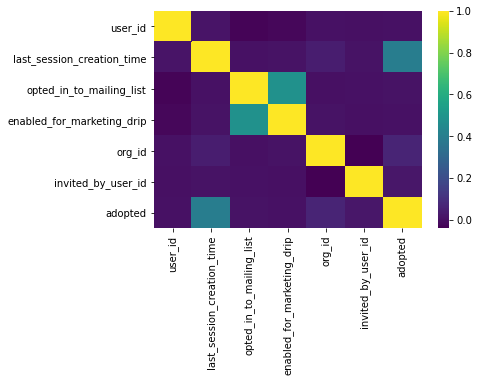

In [68]:
#let's see if a heatmap of pearson correclations can help us
cr = users.corr()
sns.heatmap(cr, cmap='viridis')
plt.show()

The heatmap isn't very helpful in this case. We can look at the individual columns and how they breakdown in percentage of users who are adopted vs not.

In [69]:
#simplifying some column names
users.rename(columns={'opted_in_to_mailing_list':'mail', 'enabled_for_marketing_drip':'marketing'}, inplace=True)

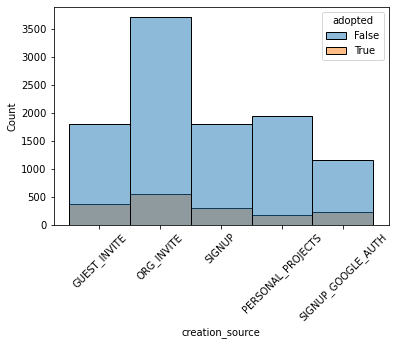

In [70]:
#Let's plot each creation source with there level of adopted
sns.histplot(data=users, x='creation_source', hue='adopted')
plt.xticks(rotation=45)
plt.show()

In [71]:
#with the small differences, it would be better to look at a numerical table of the above data
c_source = users.groupby(['adopted','creation_source']).count()['user_id'].unstack()
c_source_per = c_source/c_source.sum()*100
pd.options.display.float_format = '{:.2f}%'.format
c_source_per

creation_source  GUEST_INVITE  ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  \
adopted                                                                
False                  83.36%      87.00%             92.23%  85.96%   
True                   16.64%      13.00%              7.77%  14.04%   

creation_source  SIGNUP_GOOGLE_AUTH  
adopted                              
False                        83.25%  
True                         16.75%

In [72]:
#how does this compare to the overall percentage of adopted users
c_a = users.groupby(['adopted']).count()['user_id']
c_a_per = c_a/c_a.sum()*100
pd.options.display.float_format = '{:.2f}%'.format
c_a_per

adopted
False   86.65%
True    13.35%
Name: user_id, dtype: float64

Let's take a look at creation time of account. We can create a column for days since creation to simplify.

In [73]:
#transform into datetime object
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [74]:
#We will count days from the first account creation as we don't have other information to base a start time from
users['duration'] = users['creation_time'] - users['creation_time'].min()
users['duration'] = users['duration'].dt.days
users['duration']

0        691
1        533
2        292
3        355
4        231
        ... 
11995    463
11996    224
11997    696
11998      0
11999    605
Name: duration, Length: 12000, dtype: int64

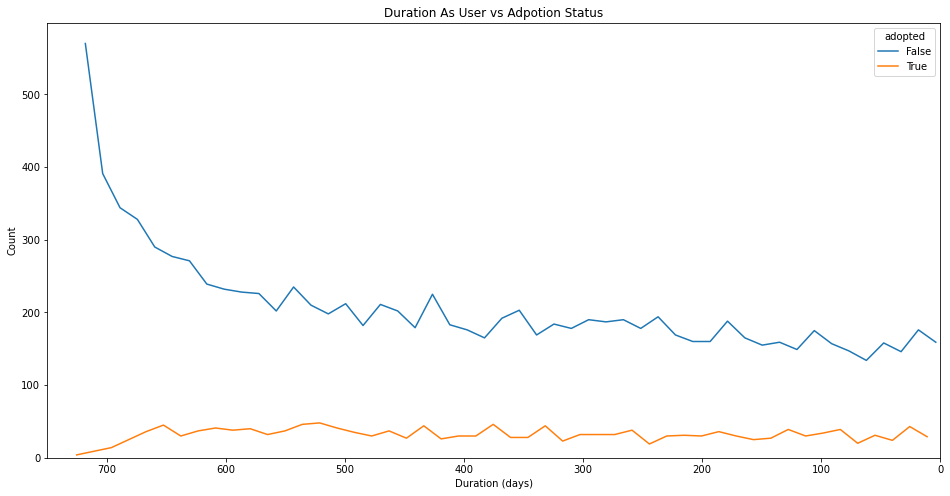

In [75]:
#Plotting nuber of adopted users and non adopted users vs days since account creation
plt.figure(figsize=(16,8))
sns.histplot(data=users, x='duration', hue='adopted', multiple='dodge', bins=50, element='poly', fill=False)
plt.xlim((750,0))
plt.title('Duration As User vs Adpotion Status')
plt.xlabel('Duration (days)')
plt.show()

There doesn't appear to be a good correclation as the balance has stabalized after an the initial surge of new customers

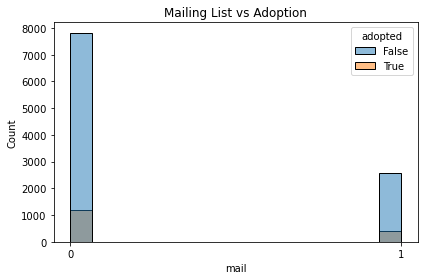

In [76]:
#let's see if being part of the mailing list increases adoption
plt.figure(figsize=(6,4))
sns.histplot(data=users, x='mail', hue='adopted')
plt.title('Mailing List vs Adoption')
plt.xticks([0,1])
plt.tight_layout()
plt.show()

In [77]:
#again a numerical table is better here 
c_source = users.groupby(['adopted','mail']).count()[['user_id']].unstack()
c_source_per = c_source/c_source.sum()*100
pd.options.display.float_format = '{:.2f}%'.format
c_source_per

user_id       
mail          0      1
adopted               
False    86.81% 86.17%
True     13.19% 13.83%

There is no boost from the mailing list

In [78]:
#let's take a look at a numerical breakdown for marketing drip
c_source = users.groupby(['adopted','marketing']).count()[['user_id']].unstack()
c_source_per = c_source/c_source.sum()*100
pd.options.display.float_format = '{:.2f}%'.format
c_source_per

user_id       
marketing       0      1
adopted                 
False      86.72% 86.27%
True       13.28% 13.73%

In [79]:
#we can take a look at the top organizations by user numbers and see if they have strong adoption rates
counts = users['org_id'].value_counts()
c = counts[counts > 50].index
f = users.loc[users['org_id'].isin(c), ['org_id','adopted','user_id']].groupby(['org_id','adopted'])['user_id'].count()
f

org_id  adopted
0       False      308
        True        11
1       False      219
        True        14
2       False      186
                  ... 
32      True         4
33      False       48
        True         9
40      False       50
        True         7
Name: user_id, Length: 68, dtype: int64

In [80]:
#Let's short by the best adoption rates
f2=f.unstack().T
f3=f2/f2.sum()*100
f3.T.sort_values(by=True, ascending=False).head(10)

adopted  False  True 
org_id               
13      80.56% 19.44%
31      83.33% 16.67%
24      84.13% 15.87%
33      84.21% 15.79%
7       86.55% 13.45%
20      86.76% 13.24%
19      86.79% 13.21%
25      87.10% 12.90%
15      87.50% 12.50%
40      87.72% 12.28%

While I would have thought the the larger adoption rates, only the five largest have percentages over the overall and some just barely over. Org 13 does have an excellent adoption rate of 19.44% though so they are someone we want to look to do further business with.

In [81]:
#creating a boolean column for whether someone was invited by a user
users.loc[users['invited_by_user_id']!=0, 'invited_by_user_id'] = 1
users['invited_by_user_id']=users['invited_by_user_id'].astype('int')

In [82]:
#Let's look at a numerical table for whether or not user who were invited have better adoption rates
c_source = users.groupby(['adopted','invited_by_user_id']).count()[['user_id']].unstack()
c_source_per = c_source/c_source.sum(axis=0)*100
pd.options.display.float_format = '{:.2f}%'.format
c_source_per

user_id       
invited_by_user_id       0      1
adopted                          
False               87.66% 85.77%
True                12.34% 14.23%

There is some difference though it is small.

In [83]:
pd.options.display.float_format = '{:.2f}'.format
users.head()

user_id       creation_time creation_source  last_session_creation_time  \
0        1 2014-04-22 03:53:30    GUEST_INVITE               1398138810.00   
1        2 2013-11-15 03:45:04      ORG_INVITE               1396237504.00   
2        3 2013-03-19 23:14:52      ORG_INVITE               1363734892.00   
3        4 2013-05-21 08:09:28    GUEST_INVITE               1369210168.00   
4        5 2013-01-17 10:14:20    GUEST_INVITE               1358849660.00   

   mail  marketing  org_id  invited_by_user_id  adopted  duration  
0     1          0      11                   1    False       691  
1     0          0       1                   1     True       533  
2     0          0      94                   1    False       292  
3     0          0       1                   1    False       355  
4     0          0     193                   1    False       231

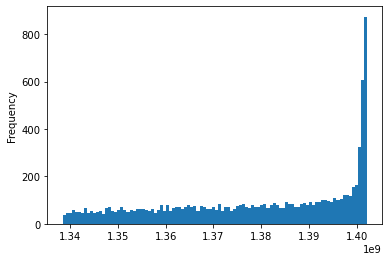

In [86]:
users.rename(columns={'last_session_creation_time':'last'}, inplace=True)
users['last'].plot(kind='hist', bins=100)
plt.show()

In [87]:
users['last']=pd.to_datetime(users['last'], unit='s')

In [88]:
users['last']

0       2014-04-22 03:53:30
1       2014-03-31 03:45:04
2       2013-03-19 23:14:52
3       2013-05-22 08:09:28
4       2013-01-22 10:14:20
                ...        
11995   2013-09-06 06:14:15
11996   2013-01-15 18:28:37
11997   2014-04-27 12:45:16
11998   2012-06-02 11:55:59
11999   2014-01-26 08:57:12
Name: last, Length: 12000, dtype: datetime64[ns]

In [99]:
users['duration_last']=users['last'].max() - users['last']
users['duration_last'] = users['duration_last'].dt.days
users['duration_last']

0        45.00
1        67.00
2       443.00
3       380.00
4       500.00
         ...  
11995   273.00
11996   506.00
11997    40.00
11998   734.00
11999   131.00
Name: duration_last, Length: 12000, dtype: float64

In [109]:
user_vcount = engage.groupby('user_id')['visited'].count().sort_values()
user_vcount = user_vcount.reset_index()

In [111]:
users = users.merge(user_vcount, on='user_id')

In [113]:
users.head()

user_id       creation_time creation_source                last  mail  \
0        1 2014-04-22 03:53:30    GUEST_INVITE 2014-04-22 03:53:30     1   
1        2 2013-11-15 03:45:04      ORG_INVITE 2014-03-31 03:45:04     0   
2        3 2013-03-19 23:14:52      ORG_INVITE 2013-03-19 23:14:52     0   
3        4 2013-05-21 08:09:28    GUEST_INVITE 2013-05-22 08:09:28     0   
4        5 2013-01-17 10:14:20    GUEST_INVITE 2013-01-22 10:14:20     0   

   marketing  org_id  invited_by_user_id  adopted  duration  duration_last  \
0          0      11                   1    False       691          45.00   
1          0       1                   1     True       533          67.00   
2          0      94                   1    False       292         443.00   
3          0       1                   1    False       355         380.00   
4          0     193                   1    False       231         500.00   

   visited  
0        1  
1       14  
2        1  
3        1  
4        1

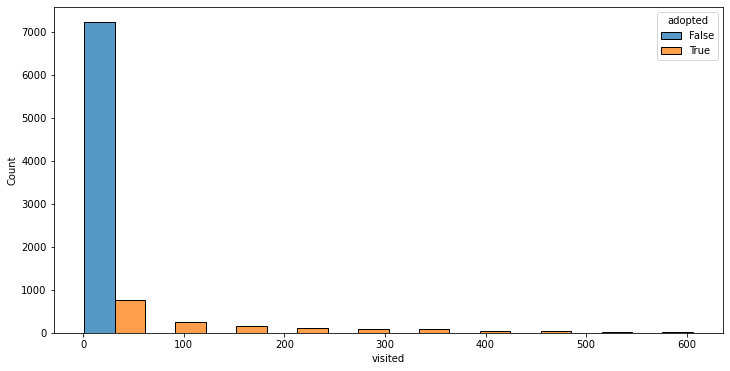

In [141]:
plt.figure(figsize=(12,6))
sns.histplot(data=users, hue='adopted', x='visited', bins=10, multiple='dodge')
plt.show()

The more visits over the users lifetime, the more likely they are adopted. Lets see where the switch happens

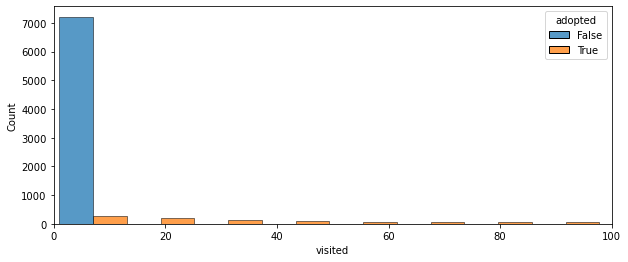

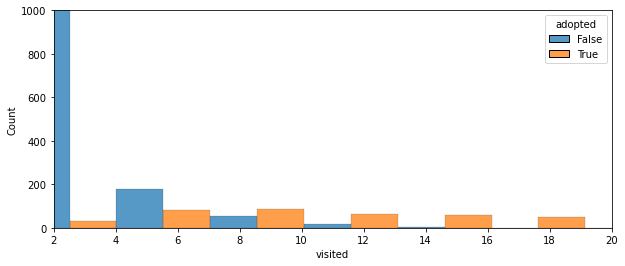

In [153]:
plt.figure(figsize=(10,4))
sns.histplot(data=users, hue='adopted', x='visited', bins=50, multiple='dodge')
plt.xlim((0,100))

plt.figure(figsize=(10,4))
sns.histplot(data=users, hue='adopted', x='visited', bins=200, multiple='dodge')
plt.xlim((2,20))
plt.ylim((0,1000))

plt.show()

The switch over seems to happen at around 8 visits

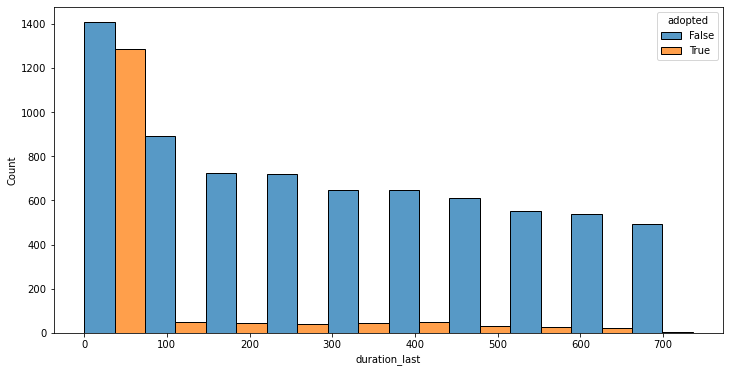

In [145]:
plt.figure(figsize=(12,6))
sns.histplot(data=users, hue='adopted', x='duration_last', bins=10, multiple='dodge')
plt.show()

The shorter the duration, especially within 100 days, from last log in seems to be a great indicator. Let's see if we can drill in closer

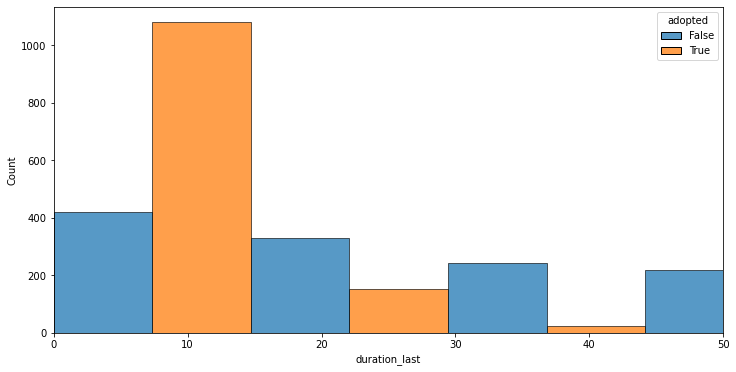

In [146]:
plt.figure(figsize=(12,6))
sns.histplot(data=users, hue='adopted', x='duration_last', bins=50, multiple='dodge')
plt.xlim((0,50))
plt.show()

It would seem that it is more specifically users who have logged in in the past month (less than 30 days)

### Let's throw a RandomForest at it and see what the feature importances come back with

In [114]:
train = users.drop(columns=['user_id','creation_time','last'])

In [120]:
dum = pd.get_dummies(train['creation_source'])
dum

GUEST_INVITE  ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  SIGNUP_GOOGLE_AUTH
0                1           0                  0       0                   0
1                0           1                  0       0                   0
2                0           1                  0       0                   0
3                1           0                  0       0                   0
4                1           0                  0       0                   0
...            ...         ...                ...     ...                 ...
8818             0           1                  0       0                   0
8819             0           0                  0       0                   1
8820             1           0                  0       0                   0
8821             0           0                  1       0                   0
8822             0           0                  0       1                   0

[8823 rows x 5 columns]

In [121]:
train.drop(columns=['creation_source'], inplace=True)
train = train.merge(dum, left_index=True, right_index=True)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['adopted']), train['adopted'], test_size = 0.3, random_state=42)


In [123]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

array([0.00310818, 0.00271201, 0.02729307, 0.00169715, 0.06795748,
       0.23166928, 0.6572091 , 0.00207416, 0.0018447 , 0.00122783,
       0.00181487, 0.00139218])

In [131]:
train.columns

Index(['mail', 'marketing', 'org_id', 'invited_by_user_id', 'adopted',
       'duration', 'duration_last', 'visited', 'GUEST_INVITE', 'ORG_INVITE',
       'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [132]:
pd.DataFrame(rf.feature_importances_, index=X_train.columns)

0
mail               0.00
marketing          0.00
org_id             0.03
invited_by_user_id 0.00
duration           0.07
duration_last      0.23
visited            0.66
GUEST_INVITE       0.00
ORG_INVITE         0.00
PERSONAL_PROJECTS  0.00
SIGNUP             0.00
SIGNUP_GOOGLE_AUTH 0.00

This agrees with what we found. The greater number of visits and short time from last session are the best indicators of someone being an adopted user.